<h2>es10: Simulated Annealing, MPI parallelization of genetic algorithm<h2>

In simulated annealing, we employ a single instance of the CodePerm class used in the previous exercice, which is called Sampler. The value of the cost function evaluated at Sampler is treated as an energy to give it a Boltzmann weigth $p = e^{-Cost/T}$, where the reduced temperature T is a tunable parameter dictating the stability of the system. 

For our simulation, 1024  ( = $32^2$ ) values of T logarithmically spaced from \[number of cities\] to 0.01 have been chosen (the idea is that, being the typical lenght of an unordered path about the same than the number of cities, the initial temperature is comparable to the initial value of cost function). 

The system starts performing Monte Carlo moves (corresponding to applying to Sampler the mutations already implemented for the genetic algorithms ), with  Metropolis acceptance based on the "fake" Boltzmann weigths, at hig temperature, and let thermalize (1000 steps). Then the temperature is lowered to the following value in the set and Sampler performs 1000 more steps, and so on. The reason for choosing so many temperatures is that this way the number of temperatures is abuot the same size of the populations used in the previous exercice, and slow cooling is key to a good search for the optimum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random

In [2]:
#parameters for reading files
names = ["circle", "square"]
dirname = "exercices/output/dir10"
filenames = ["annealing_progress_" + name + ".dat" for name in names]
coordfiles = ["annealing_" + name + "_points.dat" for name in names]

In [3]:
#load data
temps = []

acceptances = [] 

meanLengths = [] #mean length during each temperature; chiefly significant 
                 #at low temperatures since it reflects the fact that less "expensive" paths are visited more often
bestLengths = []

bestSequences = []


for filename in filenames:
    tempdata = np.loadtxt (dirname + '/' + filename)
    temps.append (tempdata [:,0].flatten ())
    acceptances.append (tempdata [:,1].flatten ())
    meanLengths.append (tempdata [:,2].flatten ())
    bestLengths.append (tempdata [:,3].flatten ())
    bestSequences.append (np.array (tempdata [:,4:], dtype="i"))
    
coordinates = []
    
for coordfile in coordfiles:
    coordinates.append (np.loadtxt (dirname + '/' + coordfile))

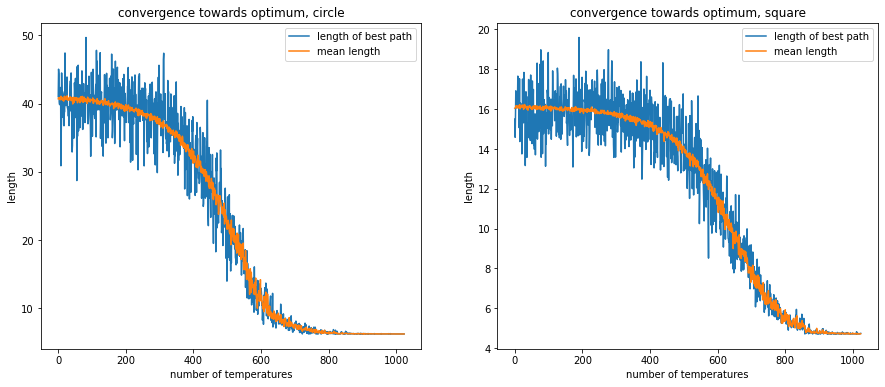

In [4]:
#plot convergence
fig, axes = plt.subplots (1,2)
fig.set_size_inches (15,6)

for ax, name, acceptance, meanLength, bestLength, bestSequence in zip (axes, names, 
                                                                   acceptances, meanLengths, bestLengths, bestSequences):
    x = range (meanLength.shape[0])
    ax.plot (x, bestLength, label="length of best path")
    ax.plot (x, meanLength, label="mean length")
    ax.legend ()
    
    ax.set_xlabel ("number of temperatures")
    ax.set_ylabel ("length")
    ax.set_title ("convergence towards optimum, "+ name)
    
    
    
    

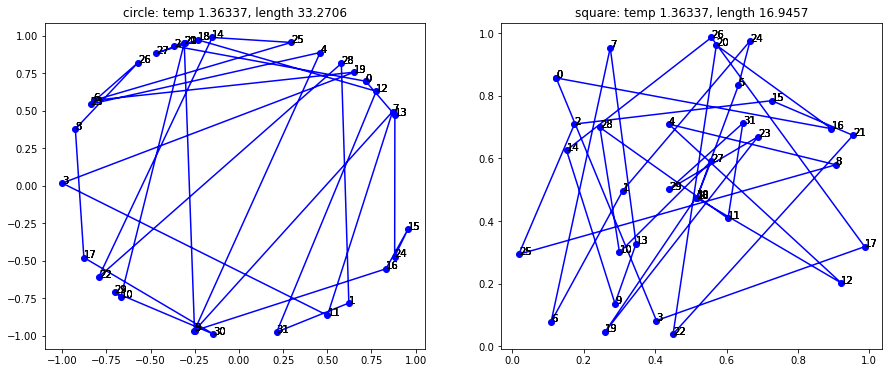

In [5]:
import time
from IPython import display

#plot best path
fig, axes = plt.subplots (1,2)
fig.set_size_inches (15,6)

picksome = 100
ntemps = temps [0].shape [0]


for tempCirc, tempSq, bestLcirc, bestLsq, seqCirc, seqSq in zip (
    temps[0] [::picksome], temps[1] [::picksome], bestLengths [0] [::picksome], 
    bestLengths [1] [::picksome], bestSequences [0] [::picksome], bestSequences [1] [::picksome]):
    
    tempCS = [tempCirc, tempSq]
    lCS = [bestLcirc, bestLsq]
    seqCS = [seqCirc, seqSq]
    
    try:
        
        for t, l, s, name, ax, coord in zip (tempCS, lCS, seqCS, names, axes, coordinates):
            ax.set_title ("{}: temp {:<6}, length {:<6}".format (name, t, l))

            for x, y, text in zip(coord[0], coord[1], range(coord[0].shape[0])):
                ax.text(x, y, text)


            x_s = np.append (coord [0] [s] , [coord [0,0]]) #appending first city at the end. we already know 
            y_s = np.append (coord [1] [s] , [coord [1,0]]) #the first visited one is 0-th one
            ax.plot (x_s, y_s, "-o", color="blue")

        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.00001)
        
    
        for ax in axes:
            ax.lines [0].remove()
            
    except KeyboardInterrupt:
        break
    
        
        
    
    
    

<h5>10-2: try and implement a Continent Genetic algorithm using MPI<h5>

In order to implement Continent GA, one creates several (one for each core) populations, and lets them evolve indipendently, but for the exchange of best individuals at fixed intervals.
First of all, we must therefore find out how many individuals the continents should exchange. The number should be big enough, so that, when producing the following generation, it is likely to pick one of the parents from the new individuals, but not such big that both parents are likely to be chosen among them. Instead of choosing a number arbitrarily, it was decided to carry out simulations with different values of the two main parameters:

<ol>
<li>the number of exchanged individuals, (nMigrants) and</li>
<li>the number of generation that each process should run alone without interaction with the others (nGenerations)</li>
</ol>

The values for point 1) were chosen from 1 to 10, whereas the number of generations ranges from 2 to 5.
    In order to evaluate the performance corresponding to the different choiches, an exit condition has been posed so that after 30 generations (in each process)  with no improvement the program terminates.
    Below is the summary of the obtained performances

In [6]:
import myPythonModule as my

parameters = [my.measurements (nfields=5, nquantities=1, 
                               headed_file_name=dirname+"/" + name + "_saved_parameters_and_effectiveness.dat") for name in names]




reading exercices/output/dir10/circle_saved_parameters_and_effectiveness.dat
found headers:  ['nprocess', 'nMigrants', 'nGenerations', 'nTotGenerations', 'fitness']
['nprocess', 'nMigrants', 'nGenerations', 'nTotGenerations', 'fitness']  used as dictionary keys
reading exercices/output/dir10/square_saved_parameters_and_effectiveness.dat
found headers:  ['nprocess', 'nMigrants', 'nGenerations', 'nTotGenerations', 'fitness']
['nprocess', 'nMigrants', 'nGenerations', 'nTotGenerations', 'fitness']  used as dictionary keys


In [7]:
splitNprocessIndices = []
for param in parameters:
    splitNprocessIndices. append ([np.asarray(param.data[0]["nprocess"] == nprocess).nonzero() for nprocess in range (1,5) ])

    
    
print ("final fitness, split according to processes number: ")    
bestindices = []
for splitinds , param, name in zip (splitNprocessIndices, parameters, names):
    tempind = []
    for nprocess in range (4):
        print ( name, nprocess + 1, param.data[0] ["fitness"] [splitinds[nprocess]])
        tempind.append (np.asarray (param.data[0] ["fitness"] [splitinds[nprocess]] == 
                                    np.min(param.data[0]["fitness"] [splitinds[nprocess]])).nonzero())
    bestindices.append (tempind)
    
print ("total number of generations, for simulations that achieved best result in their group: ") 
smartestindices = []
for (splitinds, bestinds, param ,name) in zip (splitNprocessIndices, bestindices, parameters, names):
    tempind = []
    for nprocess, binds in enumerate (bestinds):
        print (name, nprocess +1, param.data[0] ["nTotGenerations"] [splitinds[nprocess]] [binds])
        tempind.append ( np.argmin(param.data[0] ["nTotGenerations"] [splitinds[nprocess]] [binds]) )
    smartestindices.append (tempind) 

print ("parameters, for simulations that achieved the best result with the smallest number of generations:" )
for (splitinds, bestinds, smartinds, param ,name) in zip (splitNprocessIndices, bestindices, smartestindices, parameters, names):
    for nprocess, (binds, sminds) in enumerate ( zip (bestinds, smartinds )):
        for key in ["nMigrants", "nGenerations"]:
            print (name, nprocess+1, key, param.data [0][key][splitinds[nprocess]] [binds][sminds])

final fitness, split according to processes number: 
circle 1 [6.23883 6.23883 6.23883 6.23883 6.23883 7.19861 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883]
circle 2 [6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883]
circle 3 [6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883]
circle 4 [6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883 6.23883
 6.238

Then, we perform simulations using the parameters we found and plot the results

In [8]:
fileMeans = []
fileBest = []

for name in names:
    fileMeans.append ([ "{}_processes/{}_fitness_{}.dat".format (nproc +1, name, nproc) for nproc in range (4)])
    fileBest.append (["{}_processes/{}_common_fitness.dat".format (nproc + 1, name) for nproc in range (4)])
print (fileMeans)
print (fileBest)


means = []
bestlengths = []
bestCommonlengths = []
solutions = []

coordinates = [np.loadtxt (dirname + "/{}_points.dat".format (name)) for name in names]

for ind in range(2):
    tm=[]
    tbl=[]
    tbcl=[]
    ts=[]
    for filenameM, filenameB in zip (fileMeans [ind], fileBest [ind]):
        with open (dirname + '/' + filenameM) as infileM, open (dirname + '/' + filenameB) as infileB:
            tempdataM = np.loadtxt (infileM, usecols = (0,1), unpack=True)
            tm.append (tempdataM [0])
            tbl.append (tempdataM [1])
            
            tempdataB = np.loadtxt (infileB)
            tbcl .append (tempdataB [:,0].flatten() )
            ts.append (np.array(tempdataB [-1,1:], dtype="int"))
            
    means.append (tm)
    bestlengths.append (tbl)
    bestCommonlengths.append (tbcl)
    solutions.append (ts)
        


[['1_processes/circle_fitness_0.dat', '2_processes/circle_fitness_1.dat', '3_processes/circle_fitness_2.dat', '4_processes/circle_fitness_3.dat'], ['1_processes/square_fitness_0.dat', '2_processes/square_fitness_1.dat', '3_processes/square_fitness_2.dat', '4_processes/square_fitness_3.dat']]
[['1_processes/circle_common_fitness.dat', '2_processes/circle_common_fitness.dat', '3_processes/circle_common_fitness.dat', '4_processes/circle_common_fitness.dat'], ['1_processes/square_common_fitness.dat', '2_processes/square_common_fitness.dat', '3_processes/square_common_fitness.dat', '4_processes/square_common_fitness.dat']]


In [9]:
#defining an plotting routine
def plot_parallel_results (iSetUp:int=0):
    if (iSetUp != 0):
        if (iSetUp != 1):
            raise ValueError("iSetUp must be one of 0, 1")
            
    fig = plt.figure (figsize=(15,8))
    fig.suptitle (["cities on a circle", "cities in a square"][iSetUp], fontsize=16 )
    fig.subplots_adjust(hspace=0.4)
    #figure layout
    axmean = plt.subplot (231)
    axbest = plt.subplot (232)
    axcommon = plt.subplot (233)

    axessol = [plt.subplot (2,4,4 + nproc) for nproc in range (1,5) ]

    for nproc in range (1,5):
        for ax , data in zip ([axmean, axbest, axcommon], [means, bestlengths, bestCommonlengths]):
            ax.plot (range (data[iSetUp][nproc-1].shape[0]), data[iSetUp][nproc-1], label="{} processes".format(nproc))
            ax.set_ylabel ("fitness (L2 norm length)")
            #ax.set_yscale ("log")
            ax.legend()
        for ax in [axmean, axbest]:
            ax.set_xlabel ("number of generations")

        axcommon.set_xlabel ("number of loops")

        axmean.set_title("mean length of the best half \nof population in process 0")
        axbest.set_title("length of the best individual\n in population at process 0")
        axcommon.set_title ("length of the best individual \nin the <nprocesses> populations")

        #plotting solutions
        for x, y, text in zip(coordinates [iSetUp] [0], coordinates [iSetUp] [1], range(coord[0].shape[0])):
                    axessol[nproc-1].text(x, y, text)
        x_s = np.append (coordinates [iSetUp] [0] [solutions[iSetUp] [nproc-1]] , [coordinates [iSetUp] [0,0]]) #appending first city at the end. we already know 
        y_s = np.append (coordinates [iSetUp] [1] [solutions[iSetUp] [nproc-1]] , [coordinates [iSetUp] [1,0]]) #the first visited one is 0-th one
        axessol[nproc-1].plot (x_s, y_s, "-o", color="blue")
        axessol [nproc-1].set_title ("{} processes, length {}".format(nproc, bestCommonlengths[iSetUp][nproc -1][-1]))




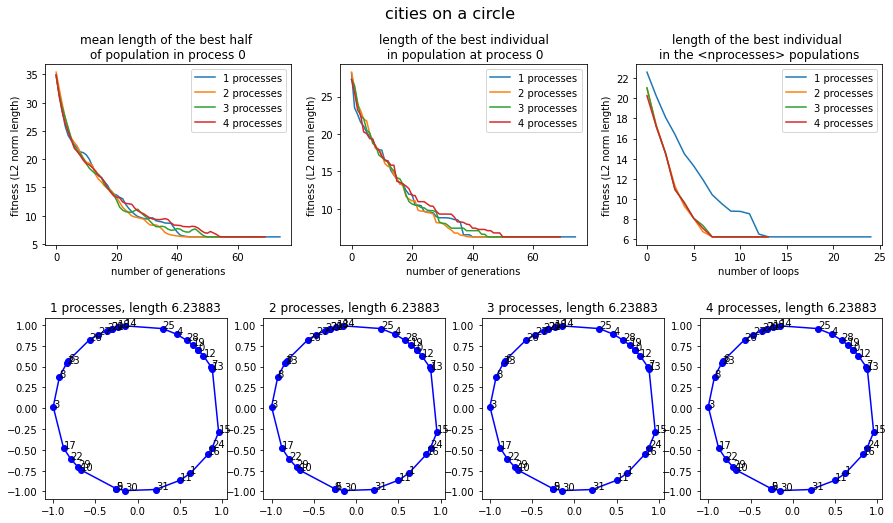

In [10]:
plot_parallel_results (0)

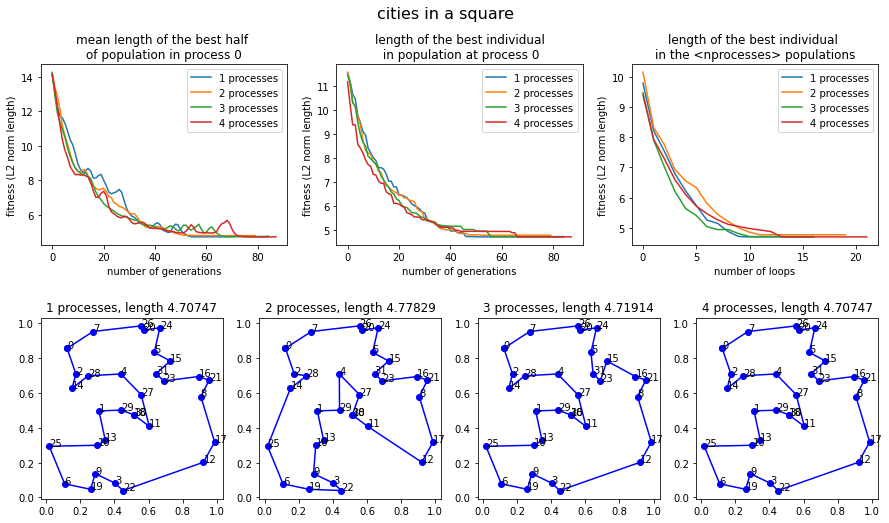

In [11]:
plot_parallel_results(1)

The parallelized algorithm performances do not vary with the number of cores in the desired way. As one can see from the first two plots in each first line, the number of generations that each core must produce before the optimum is achieved increases rather than decreasing as the number of cores raises. Also, when the number of cores is not 1, the optimum result is not always achieved, as the second and third plot in the second line of "square" show. The former issue may raise from the parameters not being well chosen, whereas the second hints at the need for a more sophisticated exit condition.

Finally, a comparison of the execution time for the several setups is made (plot below):

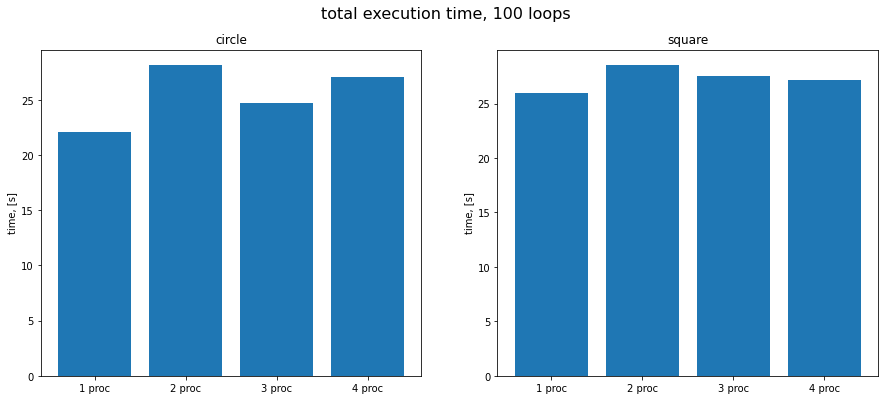

In [12]:
times = []
for name in names:
    times.append( np.loadtxt (dirname + "/saved_time10{}.dat".format(name), unpack=True))
    
fig, axes = plt.subplots (1,2)
fig.set_size_inches (15,6)

fig.suptitle ("total execution time, 100 loops", fontsize=16)
procs = ["{} proc".format(int(t)) for t in times[0][0]]
for ax, time, name in zip (axes, times, names):
    ax.set_title (name)
    ax.set_ylabel ("time, [s]")
    ax.bar (procs, time[1])

As one can see, the total execution time is always more or less the same, wich shows that parallelization does not fulfill the goal. In facts, it is telling us that each process must do almost the same amount of job as if it was alone, which was not our initial purpose.